# Lab-03: Tweaking chunking strategy of Ragas and reviewing results

### Context

In Lab-01 and Lab-02 you created an Amazon Bedrock Knowledge Base to power your RAG applicaiton. Then, you evaluated it using the RAGAS framework against different RAGAS metics and powering your RAG with different Large Language Models (llms).

In this notebook, we will work on the Amazon Bedrock Knowledge Base to observe how to improve the RAGAS metrics by changing the document chunking strategies.

### Chunking Introduction

Chunking is a critical step in building an effective knowledge base for RAG applications. The choice of chunking strategy can significantly improve or lower your RAG implementation's performance. Here's why:

1. Retrieval accuracy: Different chunking methods can lead to varying levels of precision in retrieving relevant information. An optimal chunking strategy ensures that the most pertinent information is captured in each chunk, improving the chances of retrieving the right context for a given query.

2. Context quality: The size and content of chunks directly affect the quality of context provided to the language model. Too large chunks may include irrelevant information, while too small chunks might miss important context. Finding the right balance is crucial for generating accurate and relevant responses.

3. Computational efficiency: Chunking strategies impact the number and size of vectors in your knowledge base. This, in turn, affects the computational resources required for embedding generation and similarity search. An efficient chunking strategy can lead to faster retrieval times and lower resource consumption.

4. Adaptability to content: Different types of documents (e.g., technical reports, narratives, or structured data) may benefit from different chunking approaches. The ability to tailor your chunking strategy to your specific content can significantly enhance your RAG system's performance.

<!-- ![retrieveapi.png](./images/retrieveAPI.png) -->
<img src="./assets/retrieveAPI.png" width=50% height=20% />

In the RAG workflow, chunking impacts the "Retrieve API" stage, as shown in the provided image. The process involves:

1. Generating query embeddings from the user input.
2. Retrieving similar documents (chunks) from the knowledge base.
3. Using these retrieved chunks as context for prompt augmentation.

It's important to note that there is no one-size-fits-all solution for chunking. The optimal strategy often depends on the nature of your documents, the specifics of your use case, and the characteristics of your target queries. This is why testing different chunking strategies and evaluating their impact on your RAG system's performance is crucial.

### Amazon Bedrock Knowledge Bases Chunking Strategies

Amazon Bedrock offers several chunking strategies to optimize your knowledge base for different types of content and use cases:

1. Standard Chunking:
   - Fixed-size chunking: Allows you to specify the number of tokens per chunk and an overlap percentage.
   - Default chunking: Splits content into approximately 300-token chunks, preserving sentence boundaries.
   - Pros:
       - Simple and straightforward to implement
       - Works well for uniform, well-structured documents
       - Overlap feature helps maintain context across chunk boundaries
   - Cons:
       - May split semantic units or important context
       - Less effective for documents with varying content density or structure
       - Fixed-size approach might not adapt well to diverse document types

3. Hierarchical Chunking:
   - Creates a two-level structure with parent and child chunks.
   - You can set maximum token sizes for both parent and child chunks, as well as overlap tokens.
   - Balances precision (small child chunks) with comprehensive context (larger parent chunks).
   - Pros:
       - Preserves both local and broader context
       - Allows for more nuanced retrieval (e.g., returning child chunks with parent context)
       - Can improve performance for documents with clear hierarchical structure
   - Cons:
       - More complex to set up and fine-tune
       - May introduce overhead in storage and retrieval processes
       - Might not be beneficial for flat or unstructured documents

4. Semantic Chunking:
   - Uses natural language processing to create meaningful chunks based on semantic content.
   - Configurable parameters include maximum tokens, buffer size, and breakpoint percentile threshold.
   - Aims to improve retrieval accuracy by focusing on semantic rather than just syntactic structure.
   - Pros:
       - Creates more meaningful and coherent chunks based on content
       - Can significantly improve retrieval relevance for complex documents
       - Adapts to varying content density within documents
   - Cons:
       - More computationally intensive during ingestion
       - May require more fine-tuning to achieve optimal results
       - Performance can vary depending on the effectiveness of the underlying NLP model

5. Advanced Parsing Options:
   - Utilizes foundation models (like Claude 3 Sonnet or Claude 3 Haiku) for parsing complex data such as tables and charts.
   - Allows customization of parsing prompts for specific use cases.
   - Pros:
       - Excellent for handling complex, structured data like tables and charts
       - Allows for customization to specific document types or domains
       - Can significantly improve accuracy for specialized content
   - Cons:
       - Requires more setup and potentially ongoing maintenance
       - May be overkill for simpler document types
       - Dependent on the capabilities of the chosen foundation model

6. Custom Transformation:
   - Enables the use of a Lambda function to implement custom chunking logic.
   - Useful for specific chunking requirements not natively supported by Amazon Bedrock.
   - Pros:
       - Offers maximum flexibility for unique document structures or use cases
       - Allows integration of domain-specific knowledge into the chunking process
       - Can be optimized for specific performance requirements
   - Cons:
       - Requires custom development and maintenance
       - May introduce complexity and potential points of failure
       - Can be challenging to scale or adapt to changing requirements

It's crucial to emphasize that the effectiveness of these chunking strategies can vary significantly depending on your specific use case, document types, and query patterns. Testing different strategies and carefully evaluating their impact on your RAGAS metrics is essential for optimizing your RAG implementation. This notebook will guide you through this process, helping you understand how different chunking approaches affect the performance of your knowledge base for the Octank financial reports dataset.


### Notebook Walkthrough

In this notebook we will create different Knowledge Bases with different chunking strategies based on the same dataset of previous labs.
Then, we will test each Knowledge Base created with RAGAS using `anthropic.claude-3-haiku-20240307-v1:0` as evaluator.

In the end, we will be able to observe that different chunking strategies impact the RAGAS metrics.

### Python 3.10

⚠  For this lab we need to run the notebook based on a Python 3.10 runtime. ⚠

## Creating Knowledge Bases with Different Chunking Strategies

In this section, we will create two different knowledge bases and reuse one of the knowledge bases created in Lab 1. Each knowledge base will use a different chunking strategy to process the same dataset and we will compare their performance using Ragas. 


### Steps

1. Create Knowledge Base 1: Hierarchical Transformation
   - Set maximum token size of parent to 1024 (max size of cohere embedding model)
   - Set maximum token size of child to 300
   - Set overlap tokens to 60

2. Create Knowledge Base 2: Semantic Transformation
   - Set breakpoint percentile threshold to 55
   - Set buffer size to 1
   - Set maximum tokens to 300

3. Reuse Knowledge Base from Lab 1: Fixed Chunking
   - Rerun the knowledge base creation function to reuse the already created knowledge base

### Important Notes

- Ensure you're using the same embedding model (Cohere) for all three knowledge bases to maintain consistency in our comparison.
- The Knowledge Base IDs will be crucial for our subsequent notebook operations, so make sure to record them accurately.

### First lets double check our data is uploaded to s3

In [1]:
import logging
logging.getLogger("sagemaker.config").setLevel(logging.WARNING)
import sagemaker
import boto3
import pprint
from botocore.client import Config

pp = pprint.PrettyPrinter(indent=2)
# Specify your bucket to be the default sagemaker bucket
sess = sagemaker.Session()
bucket = sess.default_bucket() #sagemaker-abcdef
filename = 'octank_financial_10K.pdf'

# Create an S3 client
s3 = boto3.client('s3')

# Upload the file
s3.upload_file(filename, bucket, filename)
print("Upload Successful!!\n")
print(f"{filename} was successfully uploaded to {bucket}/{filename}")

Upload Successful!!

octank_financial_10K.pdf was successfully uploaded to sagemaker-us-east-1-058264176820/octank_financial_10K.pdf


### Create hierarchical and semantic knowledge bases

In [2]:
import json
import boto3
from utility import interactive_sleep, create_knowledge_base, create_ds
from concurrent.futures import ThreadPoolExecutor

boto3_session = boto3.session.Session()
region_name = boto3_session.region_name

## create new hierarchical knowledge base
def create_cohere_embed_hierarchical_knowledge_base():
    return create_knowledge_base(
        index_name="cohere-embed-hierarchical",
        collection_name="cohere-embed-english-v3",
        knowledge_base_name="hierarchical-cohere-embed-english-v3",
        vector_store_name="cohere-embed-english-v3",
        access_policy_name="cohere-embed-access-policy",
        embedding_model_arn=f"arn:aws:bedrock:{region_name}::foundation-model/cohere.embed-english-v3"
    )

## create new semantic knowledge base
def create_cohere_embed_semantic_knowledge_base():
    return create_knowledge_base(
        index_name="cohere-embed-semantic",
        collection_name="cohere-embed-english-v3",
        knowledge_base_name="semantic-cohere-embed-english-v3",
        vector_store_name="cohere-embed-english-v3",
        access_policy_name="cohere-embed-access-policy",
        embedding_model_arn=f"arn:aws:bedrock:{region_name}::foundation-model/cohere.embed-english-v3"
    )

## reuse existing fixed embedding knowledge base. 
## Don't worry, this will not create a new one and will just return the old knowledge base created in Lab 1
def create_cohere_embed_fixed_knowledge_base():
    return create_knowledge_base(
        index_name="cohere-embed-english-v3",
        collection_name="cohere-embed-english-v3",
        knowledge_base_name="cohere-embed-english-v3",
        vector_store_name="cohere-embed-english-v3",
        access_policy_name="cohere-embed-access-policy",
        embedding_model_arn=f"arn:aws:bedrock:{region_name}::foundation-model/cohere.embed-english-v3"
    )

with ThreadPoolExecutor(max_workers=3) as executor:
    cohere_embed_hierarchical_future = executor.submit(create_cohere_embed_hierarchical_knowledge_base)
    cohere_embed_semantic_future = executor.submit(create_cohere_embed_semantic_knowledge_base)
    cohere_embed_fixed_future = executor.submit(create_cohere_embed_fixed_knowledge_base)
    
    cohere_embed_hierarchical_knowledge_base = cohere_embed_hierarchical_future.result()
    cohere_embed_semantic_knowledge_base = cohere_embed_semantic_future.result()
    cohere_embed_fixed_knowledge_base = cohere_embed_fixed_future.result()
    
interactive_sleep(30)
pp.pprint(f"Cohere Embed Hierarchical Knowledge Base Id: {cohere_embed_hierarchical_knowledge_base['knowledgeBaseId']}")
pp.pprint(f"Cohere Embed Semantic Knowledge Base Id: {cohere_embed_semantic_knowledge_base['knowledgeBaseId']}")
pp.pprint(f"Cohere Embed Fixed Knowledge Base Id: {cohere_embed_fixed_knowledge_base['knowledgeBaseId']}")

bedrock kb execution role arn:aws:iam::058264176820:role/amazon-sagemaker-base-executionrole
bedrock kb execution role arn:aws:iam::058264176820:role/amazon-sagemaker-base-executionrole
bedrock kb execution role arn:aws:iam::058264176820:role/amazon-sagemaker-base-executionrole
Creating index: cohere-embed-semantic

Creating index: cohere-embed-hierarchical

Index creation for index: cohere-embed-semantic complete!!..

Creating knowledge base...

Index creation for index: cohere-embed-hierarchical complete!!

Creating knowledge base...

Knowledge base: semantic-cohere-embed-english-v3-knowledge-base created!!

Knowledge base: hierarchical-cohere-embed-english-v3-knowledge-base created!!

'Cohere Embed Hierarchical Knowledge Base Id: DD7ODEUKIA'
'Cohere Embed Semantic Knowledge Base Id: TRMH6KNFIG'
'Cohere Embed Fixed Knowledge Base Id: O079GGLKHW'


### Link Data Sources and Sync

Set hierarchical and semantic chunking strategies and sync data to knowledge base. 

#### Hierarchical Chunking
<img src="./assets/hierarchical_chunking.png" width=50% height=20% />


#### Semantic Chunking
<img src="./assets/semantic_chunking.png" width=50% height=20% />

In [3]:
hierarchicalChunkingStrategyConfiguration = {
    "chunkingStrategy": "HIERARCHICAL", 
    "hierarchicalChunkingConfiguration": {
        "levelConfigurations": [{"maxTokens": 1024}, {"maxTokens": 300}], # [{maxTokens: parent chunk tokens}, {maxTokens: child chunk tokens}]
        "overlapTokens": 60 # the number of chunks to overlap in the same layers
    }
}

semanticChunkingStrategyConfiguration = {
    "chunkingStrategy": "SEMANTIC", 
    "semanticChunkingConfiguration": {
        "breakpointPercentileThreshold": 75, # the dissimilarity threshold for splitting chunks
        "bufferSize": 1, # for a given sentence, the number of sentences before or after to add to the embedding
        "maxTokens": 300 # max tokens a chunk can have
    }
}

def create_data_source(chunkingStrategyConfiguration, knowledgeBaseId):
    return create_ds(chunkingStrategyConfiguration, knowledgeBaseId, bucket)

with ThreadPoolExecutor(max_workers=2) as executor:
    cohere_embed_hierarchical_data_source_future = executor.submit(create_data_source, hierarchicalChunkingStrategyConfiguration, cohere_embed_hierarchical_knowledge_base['knowledgeBaseId'])
    cohere_embed_semantic_data_source_future = executor.submit(create_data_source, semanticChunkingStrategyConfiguration, cohere_embed_semantic_knowledge_base['knowledgeBaseId'])

    cohere_embed_hierarchical_data_source = cohere_embed_hierarchical_data_source_future.result()
    cohere_embed_semantic_data_source = cohere_embed_semantic_data_source_future.result()
    
interactive_sleep(30) ## we need to wait a little bit after the data sources finish syncing for them to be available
print("Done!")

Starting syncing job for Knowledge Base ID: AR2RIG9X4T

Starting syncing job for Knowledge Base ID: M39VOU2FLD

Sync job for Knowledge Base ID: M39VOU2FLD complete

Sync job for Knowledge Base ID: AR2RIG9X4T complete

Done!.........................


### Follow the steps below to set up necessary packages

1. Import the necessary libraries for creating `bedrock-runtime` for invoking foundation models and `bedrock-agent-runtime` client for using Retrieve API provided by Knowledge Bases for Amazon Bedrock. 
2. Import Langchain for: 
   1. Initializing bedrock model  `anthropic.claude-3-haiku-20240307-v1:0` as our large language model to perform query completions using the RAG pattern. 
   2. Initializing bedrock model  `anthropic.claude-3-haiku-20240307-v1:0` as our large language model to perform RAG evaluation. 
3. Create a `AmazonKnowledgeBasesRetriever` object from LangChain which will call the `Retrieve API` provided by Knowledge Bases for Amazon Bedrock which converts user queries into embeddings, searches the knowledge base, and returns the relevant results, giving you more control to build custom workﬂows on top of the semantic search results.

In [4]:
from langchain.llms.bedrock import Bedrock
from langchain.retrievers.bedrock import AmazonKnowledgeBasesRetriever
from langchain.chains import RetrievalQA
from langchain_aws import BedrockEmbeddings
from langchain_aws import ChatBedrock


bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={'max_attempts': 10})
bedrock_runtime_client = boto3.client('bedrock-runtime', config=bedrock_config)

kbs = [cohere_embed_hierarchical_knowledge_base, cohere_embed_semantic_knowledge_base, cohere_embed_fixed_knowledge_base] 

kwargs = {
    "temperature": 0
}

llm_for_text_generation = ChatBedrock(model_id="anthropic.claude-3-haiku-20240307-v1:0", client=bedrock_runtime_client, model_kwargs=kwargs)

llm_for_evaluation = ChatBedrock(model_id="anthropic.claude-3-haiku-20240307-v1:0", client=bedrock_runtime_client,model_kwargs=kwargs)

bedrock_embeddings = BedrockEmbeddings(model_id="cohere.embed-english-v3",client=bedrock_runtime_client)

print("LLM Clients created!!")

# Create three retrievers with the knowledge base IDs
retrievers = [
    AmazonKnowledgeBasesRetriever(
        knowledge_base_id=kb['knowledgeBaseId'],
        retrieval_config={"vectorSearchConfiguration": {"numberOfResults": 5}},
        # endpoint_url=endpoint_url,
        # region_name="us-east-1",
        # credentials_profile_name="<profile_name>",
    )
    for kb in kbs
]
print("Retrievers created!!")

LLM Clients created!!
Retrievers created!!


## Preparing the Evaluation Data

As RAGAS aims to be a reference-free evaluation framework, the required preparations of the evaluation dataset are minimal. You will need to prepare `question` and `ground_truths` pairs from which you can prepare the remaining information through inference as shown below. If you are not interested in the `context_recall` metric, you don’t need to provide the `ground_truths` information. In this case, all you need to prepare are the `questions`.

In [5]:
from datasets import Dataset

questions = [
    "What was the primary reason for the increase in net cash provided by operating activities for Octank Financial in 2021?",
    "In which year did Octank Financial have the highest net cash used in investing activities, and what was the primary reason for this?",
    "What was the primary source of cash inflows from financing activities for Octank Financial in 2021?"
]

prefix = "Keep your answers under 2000 characters in length. Only use information you are sure about from the knowledge base. "
questions = [prefix + question for question in questions]

ground_truth = [
    "The increase in net cash provided by operating activities was primarily due to an increase in net income and favorable changes in operating assets and liabilities.",
    "Octank Financial had the highest net cash used in investing activities in 2021, at $360 million, compared to $290 million in 2020 and $240 million in 2019. The primary reason for this was an increase in purchases of property, plant, and equipment and marketable securities.",
    "The primary source of cash inflows from financing activities for Octank Financial in 2021 was an increase in proceeds from the issuance of common stock and long-term debt."
]

def execute_rag(retriever):
    answers = []
    contexts = []
    kb_id = retriever.knowledge_base_id
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm_for_text_generation, retriever=retriever, return_source_documents=True
    )
    print(f"Answering questions for kb_id: {kb_id}...")
    for query in questions:
        response = qa_chain.invoke(query)
        answers.append(response["result"])
        contexts.append([docs.page_content for docs in response["source_documents"]])
    # To dict
    data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truth
    }
    return kb_id, data

datasets = {}
for retriever in retrievers:
    kb_id, data = execute_rag(retriever)
    datasets[kb_id] = Dataset.from_dict(data)

print("Questions answered and datasets created!!")

Answering questions for kb_id: M39VOU2FLD...
Answering questions for kb_id: AR2RIG9X4T...
Answering questions for kb_id: EBR1AONSY4...
Questions answered and datasets created!!


## Evaluating the RAG application
First, import all the metrics you want to use from `ragas.metrics`. Then, you can use the `evaluate()` function and simply pass in the relevant metrics and the prepared dataset.

In [6]:
from ragas import evaluate, RunConfig
from ragas.metrics import (
    answer_relevancy,
    context_precision,
    context_entity_recall,
    answer_correctness
)

#specify the metrics here
metrics = [
        answer_relevancy,
        context_precision,
        context_entity_recall,
        answer_correctness
    ]

def evaluate_kb(kb, embeddings, datasets, llm_for_evaluation):
    kb_id = kb['knowledgeBaseId']
    result = evaluate(
        dataset=datasets[kb_id],
        metrics=metrics,
        llm=llm_for_evaluation,
        embeddings=embeddings,
        run_config=RunConfig(max_workers=2)
    )
    return kb_id, result.to_pandas()

# Sequential execution
dfs = {}
for i, kb in enumerate(kbs):
    kb_id, df = evaluate_kb(kb, bedrock_embeddings, datasets, llm_for_evaluation)
    dfs[kb_id] = df

print("Ragas evaluation complete!!")

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Exception raised in Job[1]: OutputParserException(Invalid json output: The increase in net cash provided by operating activities for Octank Financial in 2021 was primarily due to an increase in net income and favorable changes in operating assets and liabilities.)


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Ragas evaluation complete!!


Below we will plot the results:

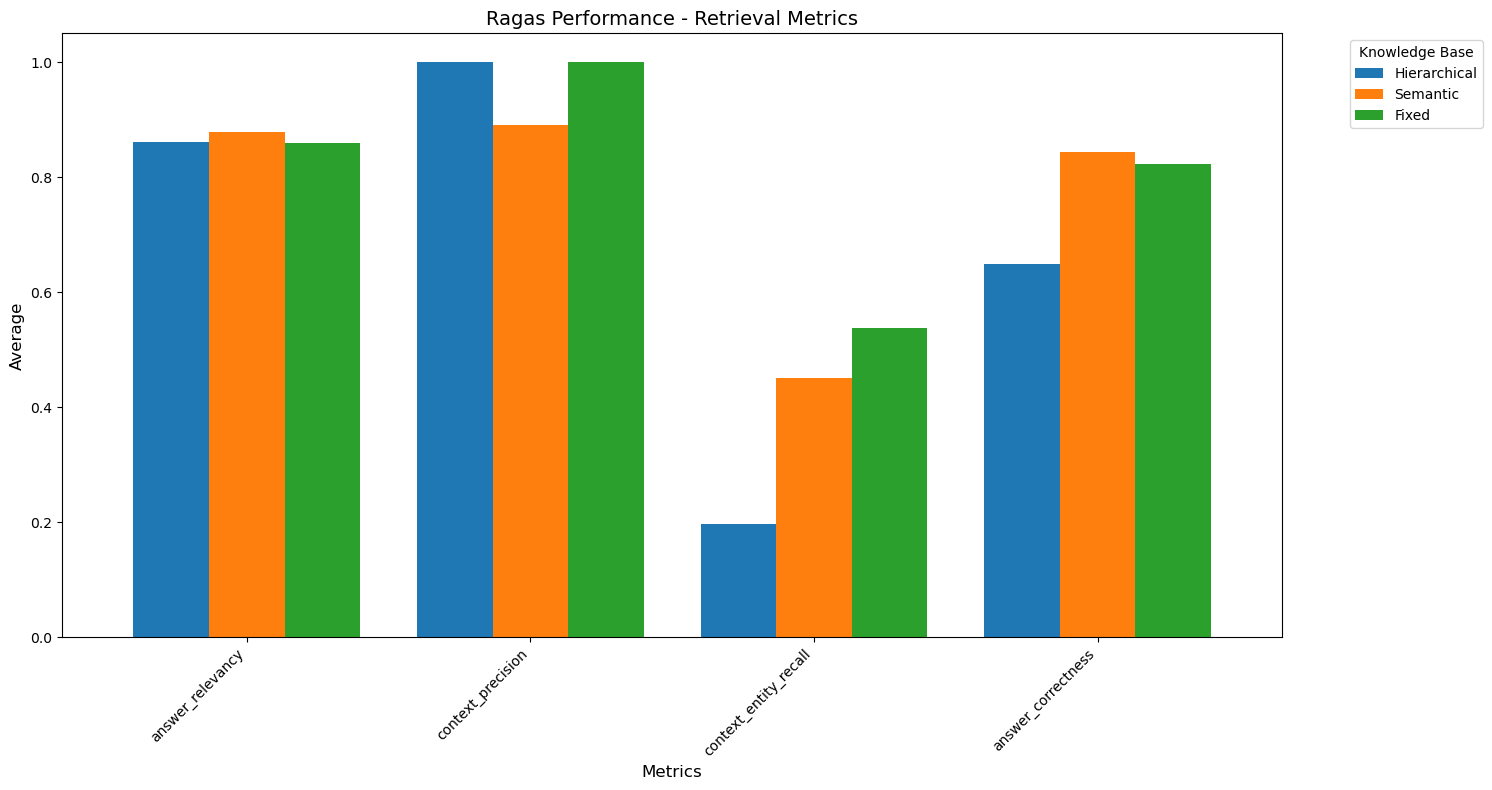

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = ['answer_relevancy', 'context_precision', 'context_entity_recall', 'answer_correctness']

# Create a mapping for display names
display_names = {
    'hierarchical-cohere-embed-english-v3-knowledge-base': 'Hierarchical',
    'semantic-cohere-embed-english-v3-knowledge-base': 'Semantic',
    'cohere-embed-english-v3-knowledge-base': 'Fixed'
}

# Calculate the mean of numeric columns for each DataFrame
means = []
kb_names = []
for key, df in dfs.items():
    mean_values = df[numeric_cols].mean()
    means.append(mean_values)
    
    # Find the corresponding KB name from the 'kbs' list
    kb_name = next((kb['name'] for kb in kbs if kb['knowledgeBaseId'] == key), 'Unknown')
    kb_names.append(kb_name)
    
# Combine the means into a single DataFrame
means_df = pd.DataFrame(means, columns=numeric_cols, index=kb_names)

# Map the index to display names
means_df.index = means_df.index.map(display_names)

# First plot (Metrics Block 1)
subset1 = means_df.iloc[:, :4]
plot_df1 = subset1.T

fig1, ax1 = plt.subplots(figsize=(15, 8))
plot_df1.plot(kind='bar', ax=ax1, width=0.8)

ax1.set_title('Ragas Performance - Retrieval Metrics', fontsize=14)
ax1.set_xlabel('Metrics', fontsize=12)
ax1.set_ylabel('Average', fontsize=12)
plt.xticks(rotation=45, ha='right')
ax1.legend(title='Knowledge Base', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()